In [1]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 38.0 MB/s eta 0:00:00:00:0100:01


In [2]:
!pip install scikit-learn==1.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 46.4 MB/s eta 0:00:0000:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [3]:
import cv2
import mediapipe as mp
import pandas as pd  
import os
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import utils
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2024-05-02 08:36:41.209692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 08:36:41.209801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 08:36:41.455675: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


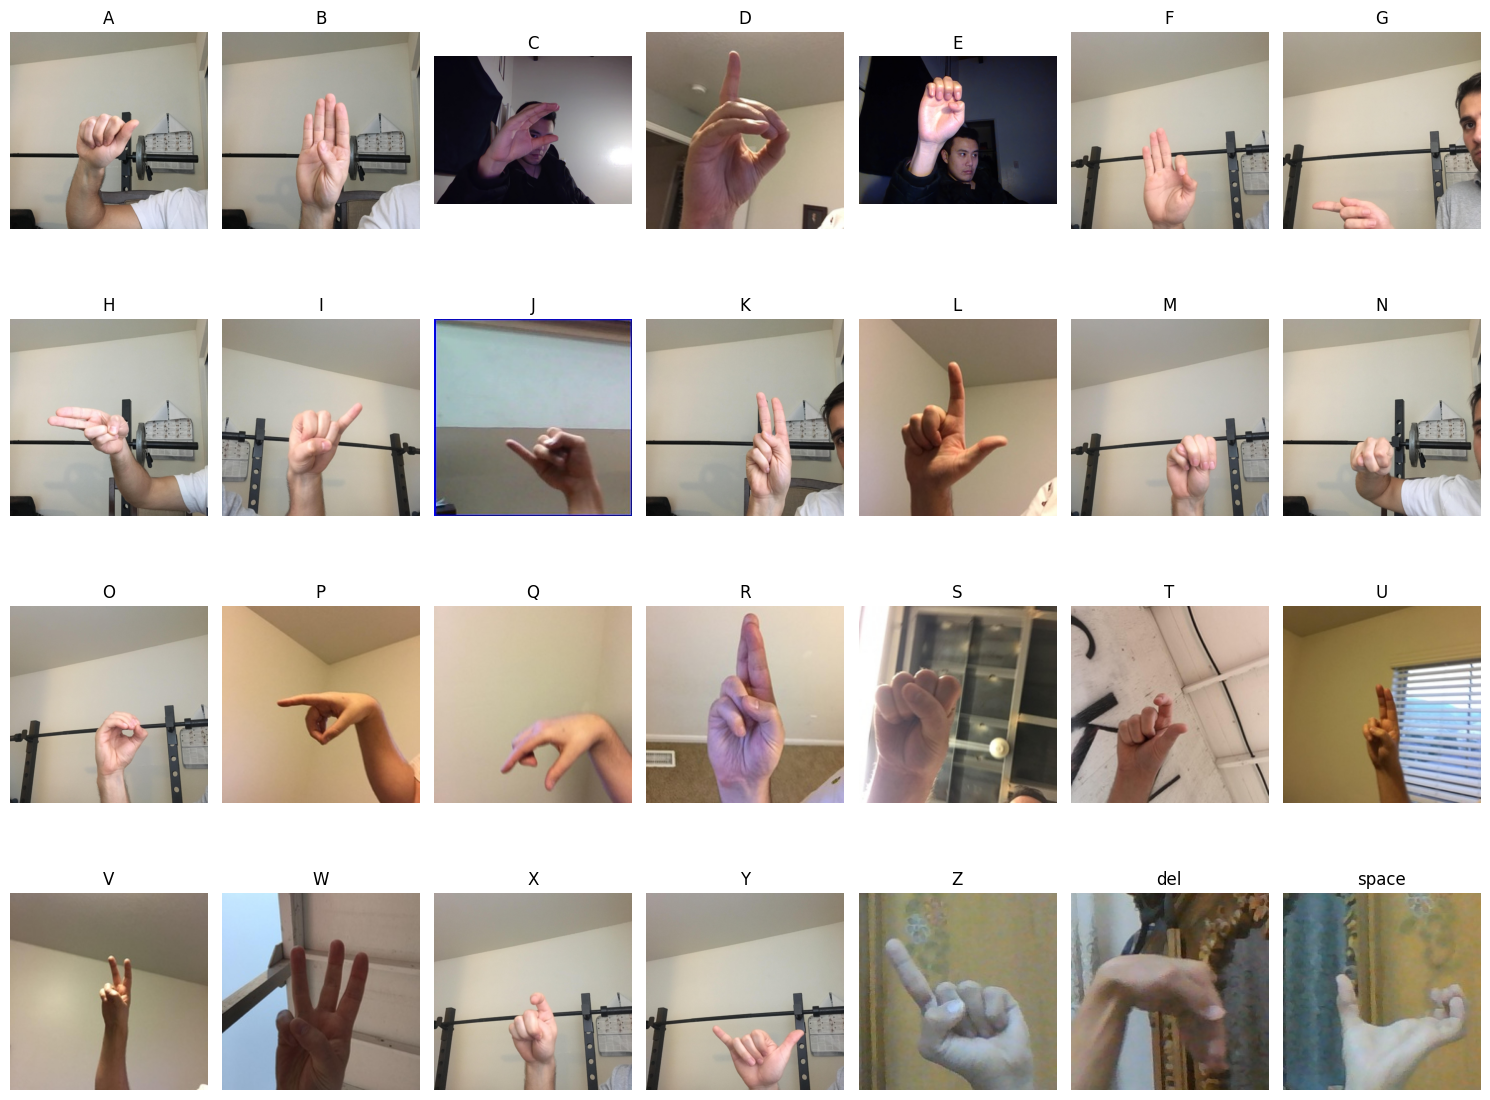

In [4]:
PATH_DIR = '/kaggle/input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset/asl_alphabet_train'

# Create a figure and axes for subplots
fig, axes = plt.subplots(4, 7, figsize=(15, 12))
dir_names = os.listdir(PATH_DIR)
dir_names.sort()
dir_names.remove('nothing')

for i, dir_name in enumerate(dir_names):
    if i < 28:
        # Calculate the row and column indices for the current image
        row = i // 7
        col = i % 7
        if dir_name == 'J':
            file_name = 'J (1002).jpg'
        elif dir_name == 'Z':
            file_name = 'Z (1).jpg'
        elif dir_name == 'space':
            file_name = 'space (1).jpg'
        elif dir_name == 'del':
            file_name = 'del (1).jpg'
        else:
            file_name = '12.jpg'
        # Construct the file path
        file_path = os.path.join(PATH_DIR, dir_name) + '/' + file_name
        
        # Open the image using PIL
        image = Image.open(file_path)
        
        # Display the image in the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].set_title(dir_name)
        axes[row, col].axis('off')
    

# Adjust the layout and spacing of subplots
plt.tight_layout()
plt.savefig('/kaggle/working/asl.png')
# Show the figure
plt.show()


In [5]:
def image_processed(file_path):
    
    # reading the static image
    hand_img = cv2.imread(file_path)

    # Image processing
    # 1. Convert BGR to RGB
    img_rgb = cv2.cvtColor(hand_img, cv2.COLOR_BGR2RGB)

    # 2. Flip the img in Y-axis
    img_flip = cv2.flip(img_rgb, 1)

    # accessing MediaPipe solutions
    mp_hands = mp.solutions.hands

    # Initialize Hands
    hands = mp_hands.Hands(static_image_mode=True,
    max_num_hands=2, min_detection_confidence=0.7)

    # Results
    output = hands.process(img_flip)

    hands.close()

    try:
        data = output.multi_hand_landmarks[0]
        #print(data)

        data = str(data)

        data = data.strip().split('\n')
        #print(data)
        garbage = ['landmark {', '  visibility: 0.0', '  presence: 0.0', '}']

        without_garbage = []

        for i in data:
            if i not in garbage:
                without_garbage.append(i)

        clean = []

        for i in without_garbage:
            i = i.strip()
            #print(i[2:])
            clean.append(i[2:])

        for i in range(0, len(clean)):
            clean[i] = float(clean[i])

        
        return(clean)

    except:
        return(np.zeros([1,63], dtype=int)[0])

In [6]:
import cv2
import mediapipe as mp

def draw_landmarks_on_image(image_path):
    # Đọc ảnh
    image = cv2.imread(image_path)

    # Chuyển đổi ảnh sang định dạng RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Khởi tạo đối tượng Mediapipe Hands
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.7)

    # Xử lý ảnh để tìm các landmarks
    results = hands.process(image_rgb)

    # Kiểm tra và vẽ landmarks nếu có
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Vẽ đánh dấu các landmarks và kết nối của bàn tay lên ảnh
            mp_drawing = mp.solutions.drawing_utils
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)



    # Hiển thị ảnh với landmarks đã được vẽ
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


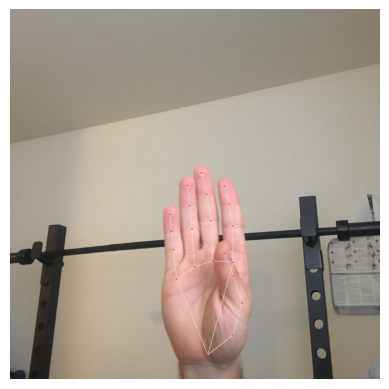

In [7]:
draw_landmarks_on_image('/kaggle/input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset/asl_alphabet_train/B/3.jpg')

In [8]:
image_processed('/kaggle/input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset/asl_alphabet_train/B/3.jpg')

[0.46265995502471924,
 0.9388958215713501,
 4.838174163523945e-07,
 0.39372071623802185,
 0.8831541538238525,
 -0.029704853892326355,
 0.37483930587768555,
 0.7942563891410828,
 -0.04192890599370003,
 0.403837651014328,
 0.7184703946113586,
 -0.05246541276574135,
 0.42573636770248413,
 0.6544479727745056,
 -0.06232992559671402,
 0.39876189827919006,
 0.6848582625389099,
 -0.009617212228477001,
 0.4005480706691742,
 0.584475040435791,
 -0.03137380629777908,
 0.40830865502357483,
 0.5246506333351135,
 -0.05307866260409355,
 0.4191831946372986,
 0.4750577509403229,
 -0.06944742798805237,
 0.45490923523902893,
 0.6794533133506775,
 -0.014679912477731705,
 0.4629250168800354,
 0.5692302584648132,
 -0.03059898130595684,
 0.47156643867492676,
 0.5004580616950989,
 -0.05271374434232712,
 0.4806528091430664,
 0.44496339559555054,
 -0.06993531435728073,
 0.5038884878158569,
 0.6960272789001465,
 -0.025333065539598465,
 0.5150452256202698,
 0.5930541157722473,
 -0.04283890873193741,
 0.5203425288

In [ ]:
def make_csv():    
    mypath = '/kaggle/input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset/asl_alphabet_train'
    file_name = open('/kaggle/working/asl_dataset.csv', 'a')

    for each_folder in os.listdir(mypath):
        if '._' in each_folder:
            pass

        else:
            if each_folder in ['J', 'Z', 'del', 'space', 'nothing']:
                file_names = os.listdir(mypath + '/' + each_folder)[:1000]
            else:
                fnames = os.listdir(mypath + '/' + each_folder)
                file_names = [file_name for file_name in fnames if not each_folder in file_name]
            for each_number in file_names:
                if '._' in each_number:
                    pass
                
                else:
                    label = each_folder

                    file_loc = mypath + '/' + each_folder + '/' + each_number

                    data = image_processed(file_loc)
                    
                    try:
                        for i in data:
                            file_name.write(str(i))
                            file_name.write(',')

                        file_name.write(label)
                        file_name.write('\n')
                    
                    except:
                        file_name.write('0')
                        file_name.write(',')

                        file_name.write('None')
                        file_name.write('\n')
       
    file_name.close()
    print('Data Created !!!')

In [ ]:
make_csv()

In [4]:
df = pd.read_csv('/kaggle/input/als-datasetfinal/asl_dataset.csv', header=None)
df = df.rename(columns={63: 'Output'})
df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,Output
0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,N
1,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,N
2,0.798181,0.470825,-6.101098e-07,0.743518,0.427192,-0.015714,0.717846,0.34457,-0.026268,0.745319,...,0.824556,0.259833,-0.054339,0.809744,0.30878,-0.042896,0.806909,0.341646,-0.028387,N
3,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,N
4,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,N


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30192 entries, 0 to 30191
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       30192 non-null  float64
 1   1       30192 non-null  float64
 2   2       30192 non-null  float64
 3   3       30192 non-null  float64
 4   4       30192 non-null  float64
 5   5       30192 non-null  float64
 6   6       30192 non-null  float64
 7   7       30192 non-null  float64
 8   8       30192 non-null  float64
 9   9       30192 non-null  float64
 10  10      30192 non-null  float64
 11  11      30192 non-null  float64
 12  12      30192 non-null  float64
 13  13      30192 non-null  float64
 14  14      30192 non-null  float64
 15  15      30192 non-null  float64
 16  16      30192 non-null  float64
 17  17      30192 non-null  float64
 18  18      30192 non-null  float64
 19  19      30192 non-null  float64
 20  20      30192 non-null  float64
 21  21      30192 non-null  float64
 22

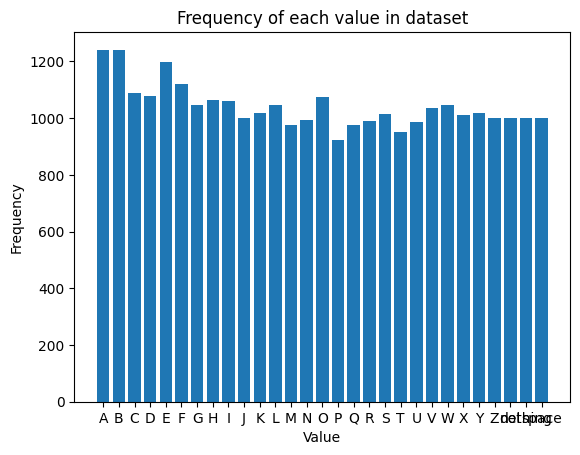

In [11]:
# Đếm số lần xuất hiện của mỗi giá trị trong cột
value_counts = df['Output'].value_counts().sort_index()

# Tạo đồ thị cột
plt.bar(value_counts.index, value_counts.values)
# Đặt tên cho các trục và tiêu đề của đồ thị
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency of each value in dataset')

# Hiển thị đồ thị
plt.show()

## Data Cleaning

In [5]:
print("Uncleaned dataset shape =", df.shape)

Uncleaned dataset shape = (30192, 64)


In [6]:
# removing null values from our dataset

all_null_values = df[df.iloc[:, 0] == 0]
print("Number of null values =", len(all_null_values))
df.drop(all_null_values.index, inplace=True)

Number of null values = 13273


In [7]:
all_nothing_values = df[df.iloc[:, 63] == 'nothing']
print("Number of nothing values =", len(all_nothing_values))

Number of nothing values = 0


In [8]:
# dropping those nothing values from our dataset

df.drop(all_nothing_values.index, inplace=True)

In [16]:
print("Cleaned dataset shape =", df.shape)

Cleaned dataset shape = (16919, 64)


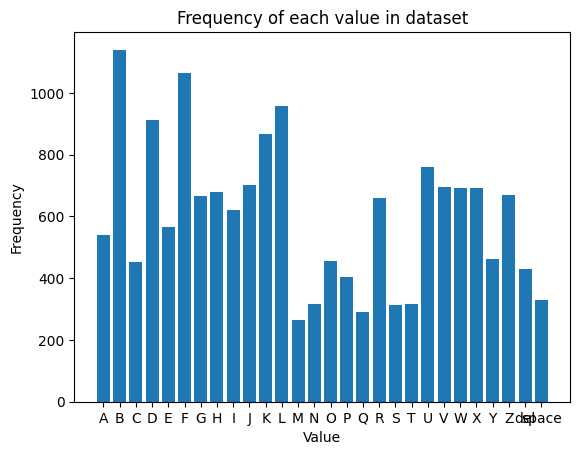

In [17]:
# Đếm số lần xuất hiện của mỗi giá trị trong cột
value_counts = df['Output'].value_counts().sort_index()

# Tạo đồ thị cột
plt.bar(value_counts.index, value_counts.values)
# Đặt tên cho các trục và tiêu đề của đồ thị
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency of each value in dataset')

# Hiển thị đồ thị
plt.show()

## Data Preparation

In [10]:
X = df.iloc[:, :-1]
print("Features shape =", X.shape)

Y = df.iloc[:, -1]
print("Labels shape =", Y.shape)

Features shape = (16919, 63)
Labels shape = (16919,)


## Data Split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [12]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=0)

In [13]:
y_train.shape, y_test.shape, y_val.shape

((10151,), (3384,), (3384,))

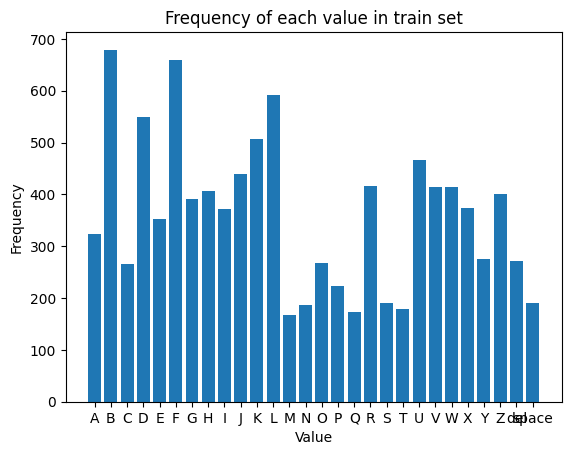

In [22]:
# Đếm số lần xuất hiện của mỗi giá trị trong cột
value_counts = y_train.value_counts().sort_index()

# Tạo đồ thị cột
plt.bar(value_counts.index, value_counts.values)
# Đặt tên cho các trục và tiêu đề của đồ thị
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency of each value in train set')

# Hiển thị đồ thị
plt.show()

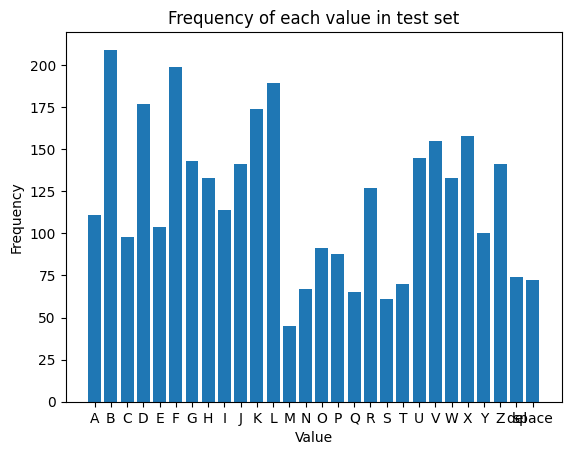

In [23]:
# Đếm số lần xuất hiện của mỗi giá trị trong cột
value_counts = y_test.value_counts().sort_index()

# Tạo đồ thị cột
plt.bar(value_counts.index, value_counts.values)
# Đặt tên cho các trục và tiêu đề của đồ thị
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency of each value in test set')

# Hiển thị đồ thị
plt.show()

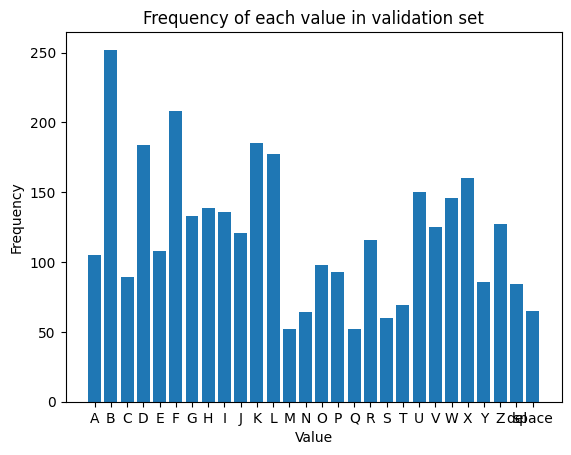

In [24]:
# Đếm số lần xuất hiện của mỗi giá trị trong cột
value_counts = y_val.value_counts().sort_index()

# Tạo đồ thị cột
plt.bar(value_counts.index, value_counts.values)
# Đặt tên cho các trục và tiêu đề của đồ thị
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency of each value in validation set')

# Hiển thị đồ thị
plt.show()

## Softmax

In [16]:
from sklearn.linear_model import LogisticRegression

lorg=LogisticRegression(multi_class='multinomial',solver='sag')
lorg.fit(x_train, y_train)

LogisticRegression(multi_class='multinomial', solver='sag')

In [17]:
y_pred = lorg.predict(x_test)
print("Testing score =", accuracy_score(y_test, y_pred))

Testing score = 0.8900709219858156


In [22]:
print("Training score =", lorg.score(x_train, y_train))

Training score = 0.9048369618756773


In [18]:
cf_matrix = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1, recall, precision

(0.8733712401946038, 0.8680700144409739, 0.8828743608675771)

<Axes: title={'center': 'Confusion Matrix - American Sign Language (Softmax)'}, xlabel='Predicted', ylabel='Actual'>

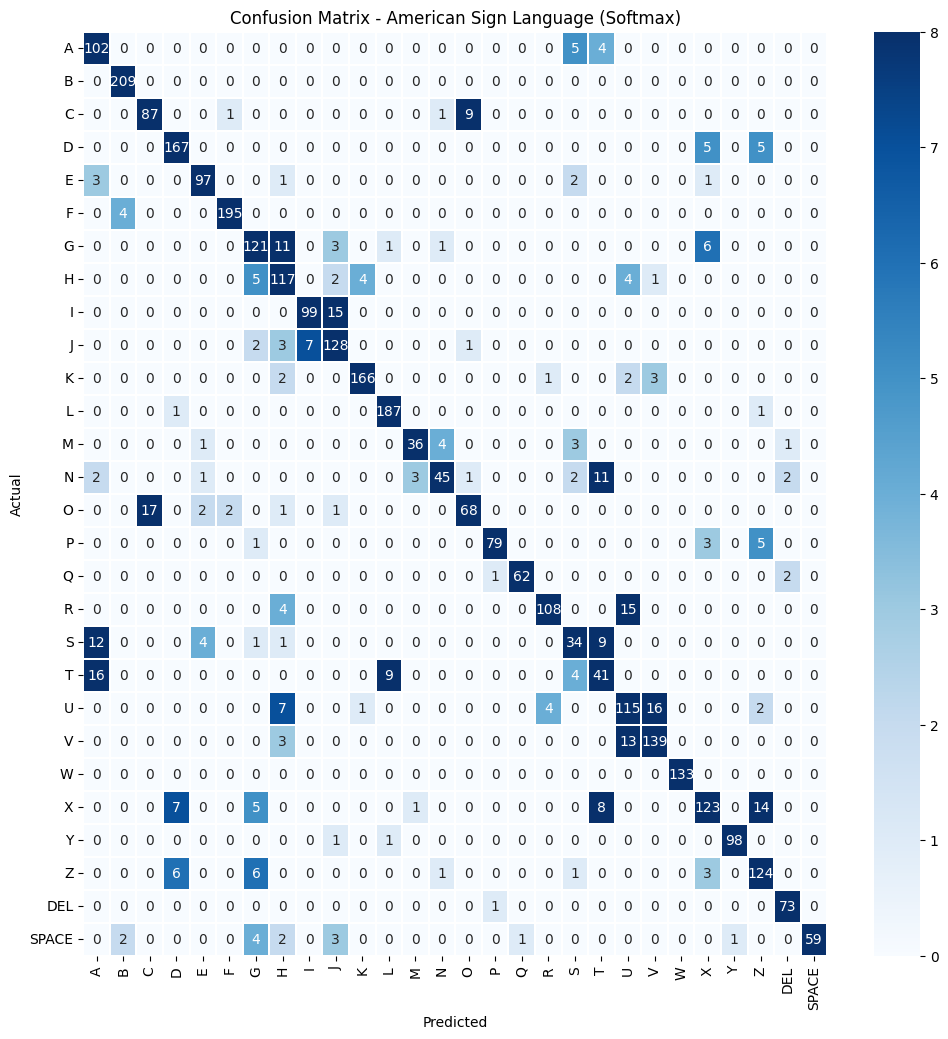

In [20]:
labels = sorted(list(set(df['Output'])))
labels = [x.upper() for x in labels]

fig, ax = plt.subplots(figsize=(12, 12))

ax.set_title("Confusion Matrix - American Sign Language (Softmax)")

maping = sns.heatmap(cf_matrix, 
                     annot=True,
                     cmap = plt.cm.Blues, 
                     linewidths=.2,
                     xticklabels=labels,
                     yticklabels=labels, vmax=8,
                     fmt='g',
                     ax=ax
                    )
plt.xlabel('Predicted')
plt.ylabel('Actual')
maping

In [21]:
maping.figure.savefig("/kaggle/working/output_softmax.png")

### SVM

In [25]:
svm = SVC(C=100, gamma=0.1, kernel='rbf')
svm.fit(x_train, y_train)

SVC(C=100, gamma=0.1)

In [26]:
print("Training score =", svm.score(x_train, y_train))
y_pred = svm.predict(x_test)
print("Testing score =", accuracy_score(y_test, y_pred))

Training score = 0.9942862772140676
Testing score = 0.9846335697399528


## Visualization

In [27]:
cf_matrix = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1, recall, precision

(0.9792147055603924, 0.9788195565363159, 0.9800117988894083)

<Axes: title={'center': 'Confusion Matrix - American Sign Language (SVM)'}, xlabel='Predicted', ylabel='Actual'>

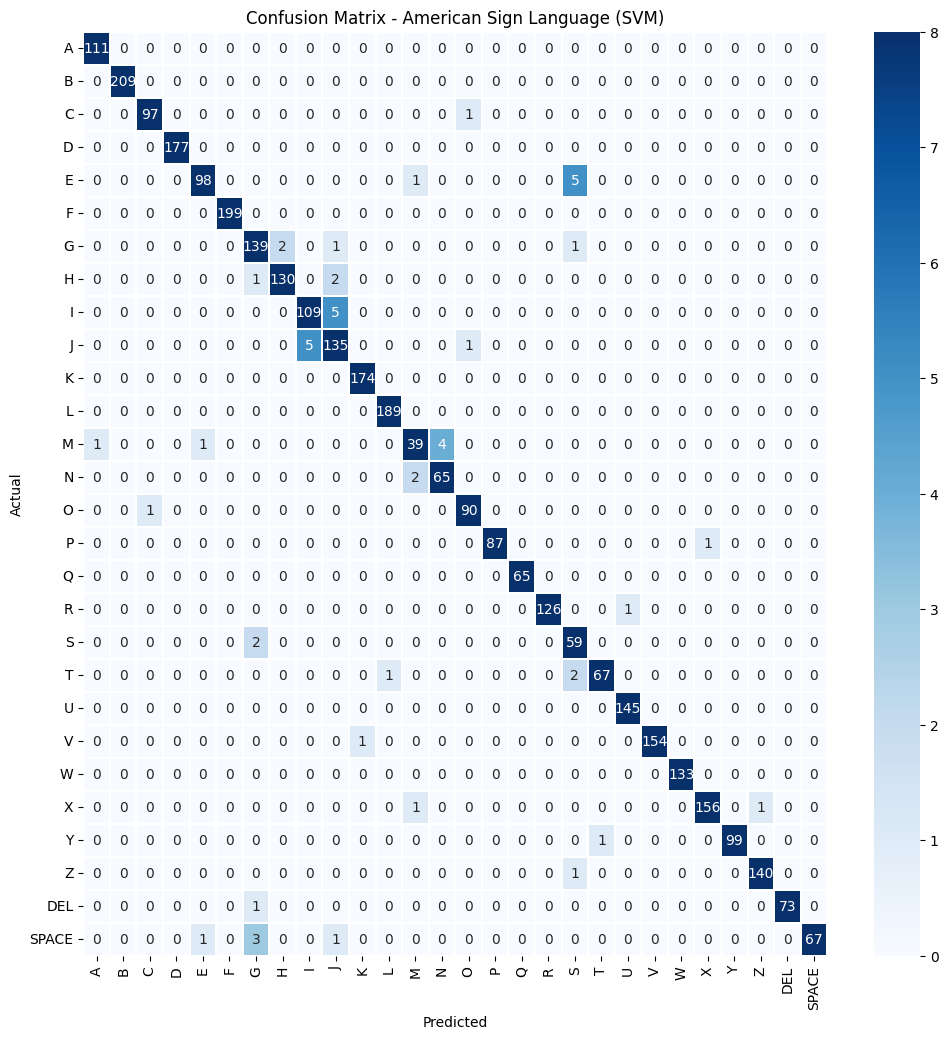

In [28]:
labels = sorted(list(set(df['Output'])))
labels = [x.upper() for x in labels]

fig, ax = plt.subplots(figsize=(12, 12))

ax.set_title("Confusion Matrix - American Sign Language (SVM)")

maping = sns.heatmap(cf_matrix, 
                     annot=True,
                     cmap = plt.cm.Blues, 
                     linewidths=.2,
                     xticklabels=labels,
                     yticklabels=labels, vmax=8,
                     fmt='g',
                     ax=ax
                    )
plt.xlabel('Predicted')
plt.ylabel('Actual')
maping

In [ ]:
maping.figure.savefig("/kaggle/working/output_svm.png")

In [ ]:
import joblib

# save
joblib.dump(svm, "/kaggle/working/model_svm.pkl") 

## ANN

In [29]:
# Check Array Shape before transformation
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
# Since the array shape is 1x1, we must turn it into 1x10x1 so we can feed it into the model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Check Array Shape after transformation
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(10151, 63)
(3384, 63)
(3384, 63)
(10151, 63, 1)
(3384, 63, 1)
(3384, 63, 1)


In [30]:
# Number of classes
num_classes = 28

# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
y_val = label_encoder.fit_transform(y_val)
# Using the Keras.Utils to put the label categorically 
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

In [31]:
label_encoder.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       'del', 'space'], dtype=object)

In [32]:
# Define the ANN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,268 (71.36 KB)

 Trainable params: 18,268 (71.36 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
#Train the Model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
 95/318 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1023 - loss: 3.2664  

I0000 00:00:1713784468.733958     155 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1645 - loss: 3.0425 - val_accuracy: 0.4852 - val_loss: 1.9138
Epoch 2/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5315 - loss: 1.6879 - val_accuracy: 0.6655 - val_loss: 1.1437
Epoch 3/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7084 - loss: 1.0579 - val_accuracy: 0.7683 - val_loss: 0.8282
Epoch 4/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7764 - loss: 0.7836 - val_accuracy: 0.8153 - val_loss: 0.6382
Epoch 5/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8155 - loss: 0.6517 - val_accuracy: 0.8310 - val_loss: 0.5729
Epoch 6/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8356 - loss: 0.5524 - val_accuracy: 0.8567 - val_loss: 0.4937
Epoch 7/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8630 - loss: 0.4940 - val_accuracy: 0.8797 - val_loss: 0.4335
Epoch 8/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8659 - loss: 0.4503 - val_accuracy: 0.8715 - val_

In [34]:
train_loss, train_accuracy = model.evaluate(x_train, y_train)
print('Train Accuracy =', train_accuracy)
print('Train Loss =', train_loss)

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8976 - loss: 0.3532
Train Accuracy = 0.8993202447891235
Train Loss = 0.3506707549095154


In [35]:
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print('Validation Accuracy =', val_accuracy)
print('Validation Loss =', val_loss)

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8959 - loss: 0.3448
Validation Accuracy = 0.8956855535507202
Validation Loss = 0.3544687032699585


In [36]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Test Accuracy =', test_accuracy)
print('Test Loss =', test_loss)

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8953 - loss: 0.4240
Test Accuracy = 0.8841607570648193
Test Loss = 0.40896543860435486


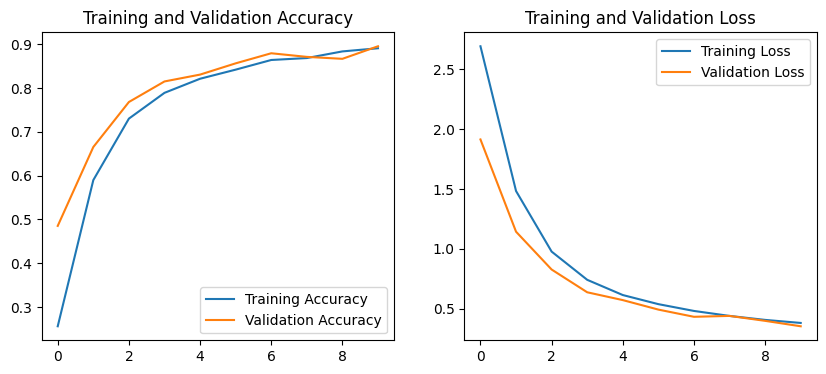

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# This code is used to plot the training and validation accuracy
epochs_range = range(len(acc))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
y_test_decode = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=-1)
cf_matrix = confusion_matrix(y_test_decode, y_pred)
f1 = f1_score(y_test_decode, y_pred, average='macro')
recall = recall_score(y_test_decode, y_pred, average='macro')
precision = precision_score(y_test_decode, y_pred, average='macro')
f1, recall, precision

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


(0.8736678589619178, 0.8704477419941477, 0.8940477565202133)

<Axes: title={'center': 'Confusion Matrix - American Sign Language (ANN)'}, xlabel='Predicted', ylabel='Actual'>

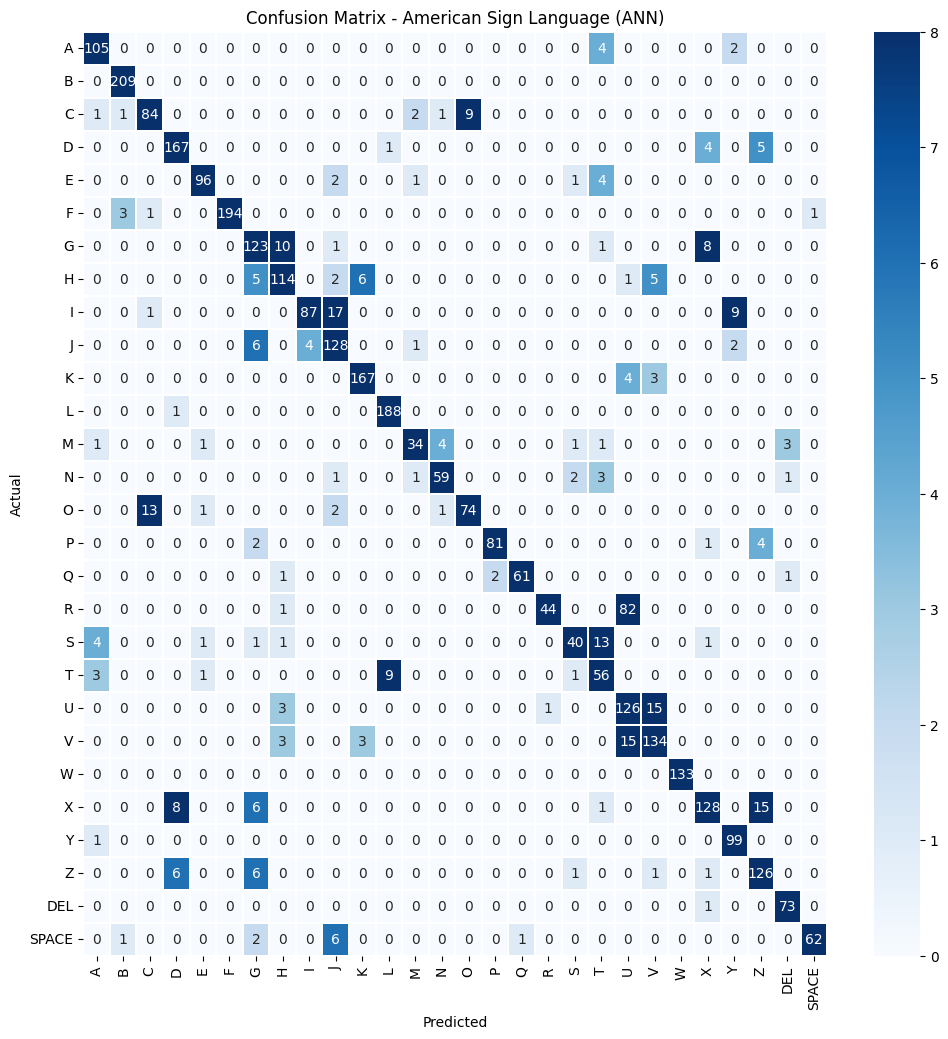

In [39]:
labels = sorted(list(set(df['Output'])))
labels = [x.upper() for x in labels]

fig, ax = plt.subplots(figsize=(12, 12))

ax.set_title("Confusion Matrix - American Sign Language (ANN)")

maping = sns.heatmap(cf_matrix, 
                     annot=True,
                     cmap = plt.cm.Blues, 
                     linewidths=.2,
                     xticklabels=labels,
                     yticklabels=labels, vmax=8,
                     fmt='g',
                     ax=ax
                    )
plt.ylabel('Actual')
plt.xlabel('Predicted')
maping

In [40]:
maping.figure.savefig("output_ann.png")

In [41]:
#Saving the model into H5 system file
save_model = "/kaggle/working/model_ann.h5"
model.save(save_model)
print("Model Saved into", save_model)

Model Saved into /kaggle/working/model_ann.h5


## CNN

In [53]:
# create dataframe from images in directory
data_path = '/kaggle/input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset/asl_alphabet_train'
root_dir = os.listdir(data_path)
root_dir.remove('nothing')
file_list = []
label_list = []

for directory in root_dir:
    directory_path = f"{data_path}/{directory}"
    if directory in ['J', 'Z', 'del', 'space', 'nothing']:
        file_names = os.listdir(directory_path)[:1000]
    else:
        fnames = os.listdir(directory_path)
        file_names = [file_name for file_name in fnames if not directory in file_name]
    for files in file_names:
        file_path = f"{data_path}/{directory}/{files}"
        file_list.append(file_path)
        label_list.append(directory)
        
df = pd.DataFrame({'file':file_list,'label':label_list})
df

,file,label
0,/kaggle/input/aslamerican-sign-language-aplhab...,N
1,/kaggle/input/aslamerican-sign-language-aplhab...,N
2,/kaggle/input/aslamerican-sign-language-aplhab...,N
3,/kaggle/input/aslamerican-sign-language-aplhab...,N
4,/kaggle/input/aslamerican-sign-language-aplhab...,N
...,...,...
29187,/kaggle/input/aslamerican-sign-language-aplhab...,J
29188,/kaggle/input/aslamerican-sign-language-aplhab...,J
29189,/kaggle/input/aslamerican-sign-language-aplhab...,J
29190,/kaggle/input/aslamerican-sign-language-aplhab...,J


In [54]:
# split dataframe into train, test, and validation
x_train, x_test0, y_train, y_test0 = train_test_split(df['file'], df['label'], test_size=0.4, random_state=0)
x_test, x_val, y_test, y_val = train_test_split(x_test0, y_test0, test_size=0.5, random_state=0)
train = pd.concat([x_train,y_train], axis=1).reset_index(drop=True)
test = pd.concat([x_test,y_test], axis=1).reset_index(drop=True)
val = pd.concat([x_val, y_val], axis=1).reset_index(drop=True)
print(np.shape(train))
print(np.shape(test))
print(np.shape(val))

(17515, 2)
(5838, 2)
(5839, 2)


In [55]:
# normalize image data and transform into train, test, and validation datasets
image_size = 150
batchsize = 32
class_size = 28

datagen = ImageDataGenerator(rescale=1.0/255)

train_data = datagen.flow_from_dataframe(dataframe=train, x_col='file', y_col='label', target_size=(image_size,image_size), batch_size = batchsize, class_mode='categorical')

test_data = datagen.flow_from_dataframe(dataframe=test, x_col='file', y_col='label', target_size=(image_size,image_size), shuffle=False, batch_size=batchsize, class_mode='categorical')

val_data = datagen.flow_from_dataframe(dataframe=val, x_col='file', y_col='label', target_size=(image_size,image_size), shuffle=False, batch_size = batchsize, class_mode='categorical')

Found 17515 validated image filenames belonging to 28 classes.
Found 5838 validated image filenames belonging to 28 classes.
Found 5839 validated image filenames belonging to 28 classes.


In [ ]:
# # normalize image data and transform into train, test, and validation datasets
# image_size = 150
# batchsize = 32
# class_size = 28

# datagen = ImageDataGenerator(rescale=1.0/255)

# def crop_hand(image):
#     # Khởi tạo mô-đun Mediapipe Hands
#     mp_hands = mp.solutions.hands.Hands(static_image_mode=True)

#     # Chuyển đổi màu sắc từ BGR sang RGB
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # Phát hiện tay trong ảnh
#     results = mp_hands.process(image_rgb)

#     # Kiểm tra xem có tay được phát hiện hay không
#     if results.multi_hand_landmarks:
#         # Lấy tọa độ các điểm đặc trưng của tay
#         hand_landmarks = results.multi_hand_landmarks[0]

#         # Tính toán tọa độ của hình chữ nhật bao quanh tay
#         x_min = min(int(lm.x * image.shape[1]) for lm in hand_landmarks.landmark) - 50
#         x_max = max(int(lm.x * image.shape[1]) for lm in hand_landmarks.landmark) + 50
#         y_min = min(int(lm.y * image.shape[0]) for lm in hand_landmarks.landmark) - 50
#         y_max = max(int(lm.y * image.shape[0]) for lm in hand_landmarks.landmark) + 50

#         # Cắt lấy phần tay từ ảnh
#         hand_image = image[y_min:y_max, x_min:x_max]

#         # Đảm bảo rằng ảnh tay không rỗng
#         if hand_image.size > 0:
#             # Resize ảnh tay về kích thước mong muốn
#             hand_image = cv2.resize(hand_image, (image_size, image_size))

#             return hand_image

#     return None

# def preprocess_image(image_path):
#     # Đọc ảnh gốc
#     image = cv2.imread(image_path)

#     # Cắt lấy phần tay từ ảnh
#     hand_image = crop_hand(image)

#     return hand_image

# # Cắt lấy phần tay từ tập train
# train['hand_image'] = train['file'].apply(preprocess_image)

# # Loại bỏ các dòng không có phần tay
# train = train.dropna()

# # Chuyển đổi ảnh tay và nhãn thành mảng numpy
# train_images = np.array(train['hand_image'].tolist())
# train_labels = np.array(train['label'].tolist())

# # Chuyển đổi nhãn thành one-hot encoding
# train_labels = pd.get_dummies(train_labels).values

# # Tạo generator cho tập train
# train_data = datagen.flow(train_images, train_labels, batch_size=batchsize)

# # Cắt lấy phần tay từ tập test
# test['hand_image'] = test['file'].apply(preprocess_image)

# # Loại bỏ các dòng không có phần tay
# test = test.dropna()

# # Chuyển đổi ảnh tay và nhãn thành mảng numpy
# test_images = np.array(test['hand_image'].tolist())
# test_labels = np.array(test['label'].tolist())

# # Chuyển đổi nhãn thành one-hot encoding
# test_labels = pd.get_dummies(test_labels).values

# # Tạo generator cho tập test
# test_data = datagen.flow(test_images, test_labels, batch_size=batchsize)

# # Cắt lấy phần tay từ tập test
# test['hand_image'] = test['file'].apply(preprocess_image)

# # Loại bỏ các dòng không có phần tay
# test = test.dropna()

# # Chuyển đổi ảnh tay và nhãn thành mảng numpy
# test_images = np.array(test['hand_image'].tolist())
# test_labels = np.array(test['label'].tolist())

# # Chuyển đổi nhãn thành one-hot encoding
# test_labels = pd.get_dummies(test_labels).values

# # Tạo generator cho tập test
# test_data = datagen.flow(test_images, test_labels, batch_size=batchsize)

# # Cắt lấy phần tay từ tập validation
# val['hand_image'] = val['file'].apply(preprocess_image)

# # Loại bỏ các dòng không có phần tay
# val = val.dropna()

# # Chuyển đổi ảnh tay và nhãn thành mảng numpy
# val_images = np.array(val['hand_image'].tolist())
# val_labels = np.array(val['label'].tolist())

# # Chuyển đổi nhãn thành one-hot encoding
# val_labels = pd.get_dummies(val_labels).values

# # Tạo generator cho tập val
# val_data = datagen.flow(val_images, val_labels, batch_size=batchsize)

In [56]:
# Initialize model
model = Sequential()

model.add(Conv2D(32, (5,5), activation = 'relu', input_shape = (image_size,image_size,3)))
# model.add(Conv2D(32, 3, activation = 'relu', padding='same'))
model.add(MaxPooling2D(padding='same')) # v3


model.add(Conv2D(64, (5,5), activation = 'relu'))
model.add(MaxPooling2D(padding='same')) # v3

# model.add(Conv2D(64, (5,5), activation = 'relu', padding='same')) #v4
# model.add(MaxPooling2D(padding='same')) # v4  0.9458598494529724

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5)) # v3

model.add(Dense(28, activation = 'softmax'))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 146, 146, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 69, 69, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 78400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │    10,035,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,092,636 (38.50 MB)

 Trainable params: 10,092,636 (38.50 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
# Train CNN model on training data
classifier = model.fit(train_data, validation_data=val_data, epochs=10, verbose=1)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


548/548 ━━━━━━━━━━━━━━━━━━━━ 244s 427ms/step - accuracy: 0.2986 - loss: 2.5306 - val_accuracy: 0.8179 - val_loss: 0.6817
Epoch 2/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 83s 149ms/step - accuracy: 0.7564 - loss: 0.7731 - val_accuracy: 0.8822 - val_loss: 0.3985
Epoch 3/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 83s 149ms/step - accuracy: 0.8393 - loss: 0.4961 - val_accuracy: 0.9087 - val_loss: 0.3186
Epoch 4/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 83s 150ms/step - accuracy: 0.8791 - loss: 0.3692 - val_accuracy: 0.9305 - val_loss: 0.2781
Epoch 5/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 83s 151ms/step - accuracy: 0.8954 - loss: 0.3097 - val_accuracy: 0.9342 - val_loss: 0.2660
Epoch 6/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 82s 149ms/step - accuracy: 0.9086 - loss: 0.2734 - val_accuracy: 0.9332 - val_loss: 0.2526
Epoch 7/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 83s 149ms/step - accuracy: 0.9273 - loss: 0.2238 - val_accuracy: 0.9411 - val_loss: 0.2402
Epoch 8/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 83s 149ms/step - accuracy: 0.9361 - loss: 0.1975 - va

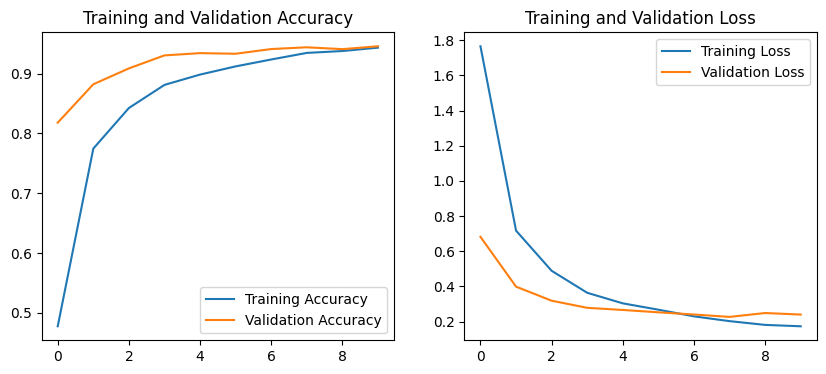

In [59]:
acc = classifier.history['accuracy']
val_acc = classifier.history['val_accuracy']

loss = classifier.history['loss']
val_loss = classifier.history['val_loss']

# This code is used to plot the training and validation accuracy
epochs_range = range(len(acc))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [60]:
train_loss, train_accuracy = model.evaluate(train_data)
print('Train Accuracy =', train_accuracy)
print('Train Loss =', train_loss)

548/548 ━━━━━━━━━━━━━━━━━━━━ 61s 112ms/step - accuracy: 0.9954 - loss: 0.0217
Train Accuracy = 0.994576096534729
Train Loss = 0.023086141794919968


In [61]:
val_loss, val_accuracy = model.evaluate(val_data)
print('Validation Accuracy =', val_accuracy)
print('Validation Loss =', val_loss)

183/183 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.9414 - loss: 0.2723
Validation Accuracy = 0.9457098841667175
Validation Loss = 0.23980730772018433


In [62]:
test_loss, test_accuracy = model.evaluate(test_data)
print('Test Accuracy =', test_accuracy)
print('Test Loss =', test_loss)

183/183 ━━━━━━━━━━━━━━━━━━━━ 68s 373ms/step - accuracy: 0.9425 - loss: 0.2500
Test Accuracy = 0.9436450600624084
Test Loss = 0.25063854455947876


In [63]:
# Predict on testing dataset and assess accuracy
probs = model.predict(test_data, verbose = 0)
y_pred = np.argmax(probs, axis = 1)
y_actual = test_data.labels

In [64]:
cf_matrix = confusion_matrix(y_actual, y_pred)
f1 = f1_score(y_actual, y_pred, average='macro')
recall = recall_score(y_actual, y_pred, average='macro')
precision = precision_score(y_actual, y_pred, average='macro')
f1, recall, precision

(0.9433520771188336, 0.9432526183813007, 0.9440933287108452)

<Axes: title={'center': 'Confusion Matrix - American Sign Language (CNN)'}, xlabel='Predicted', ylabel='Actual'>

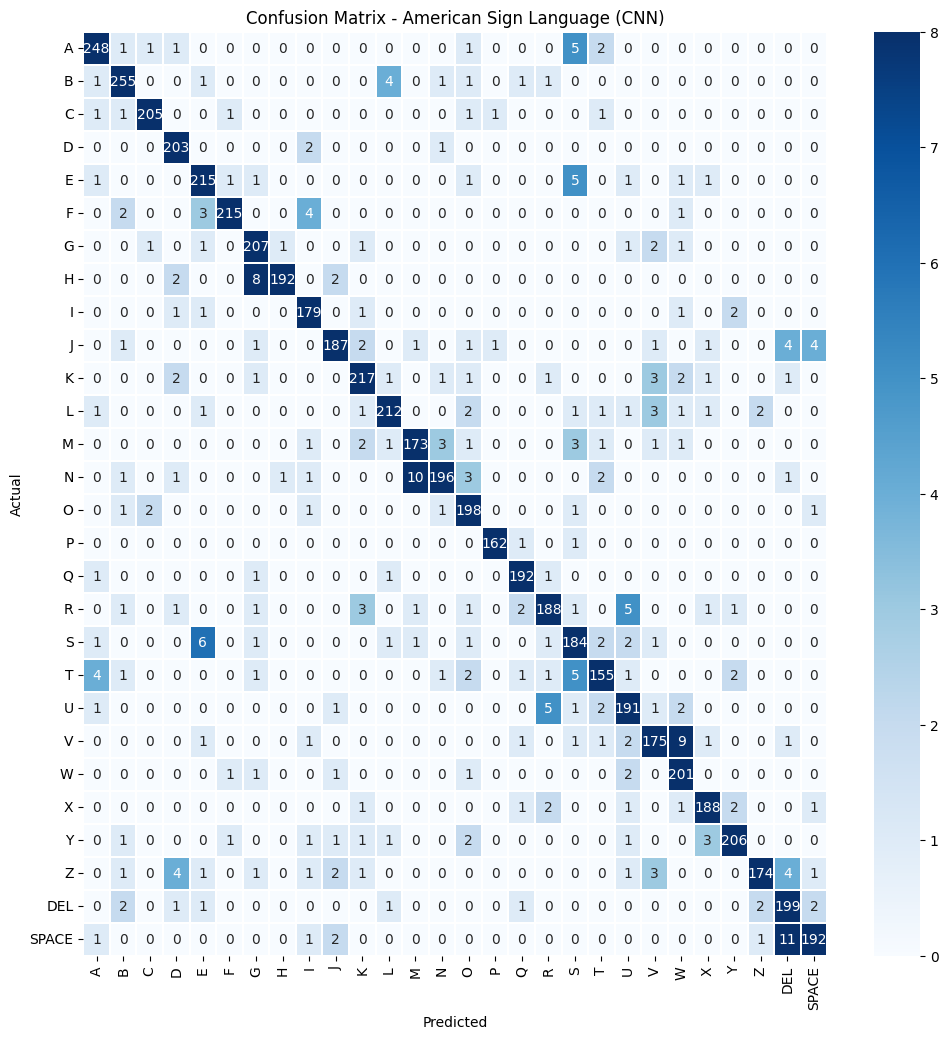

In [65]:
labels = sorted(list(set(df['label'])))
labels = [x.upper() for x in labels]

fig, ax = plt.subplots(figsize=(12, 12))

ax.set_title("Confusion Matrix - American Sign Language (CNN)")

maping = sns.heatmap(cf_matrix, 
                     annot=True,
                     cmap = plt.cm.Blues, 
                     linewidths=.2,
                     xticklabels=labels,
                     yticklabels=labels, vmax=8,
                     fmt='g',
                     ax=ax
                    )
plt.ylabel('Actual')
plt.xlabel('Predicted')
maping

In [66]:
maping.figure.savefig("/kaggle/working/output_cnn.png")

## CNN (csv)

In [42]:
# One Dimensional Convolutional Neural Network model, Train will be feed to 1 Dimension Convolutional Neural Network
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=x_train.shape[1:3]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=256, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Conv1D(filters=256, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(rate=0.2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(num_classes, activation='softmax')])

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 63, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 63, 32)         │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 31, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 31, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 31, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 15, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 15, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 7, 256)         │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 7, 256)         │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 28)             │        14,364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,059,452 (4.04 MB)

 Trainable params: 1,059,452 (4.04 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
#Train the Model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
 25/318 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0262 - loss: 3.3017

W0000 00:00:1713784652.960711     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0944 - loss: 3.0511

W0000 00:00:1713784668.339010     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


318/318 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - accuracy: 0.0948 - loss: 3.0496 - val_accuracy: 0.5269 - val_loss: 1.3706
Epoch 2/10
 42/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5128 - loss: 1.3768

W0000 00:00:1713784669.987567     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5627 - loss: 1.2168 - val_accuracy: 0.7054 - val_loss: 0.8031
Epoch 3/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7547 - loss: 0.7079 - val_accuracy: 0.7358 - val_loss: 0.8117
Epoch 4/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7927 - loss: 0.6218 - val_accuracy: 0.8614 - val_loss: 0.3919
Epoch 5/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8506 - loss: 0.4156 - val_accuracy: 0.8910 - val_loss: 0.3424
Epoch 6/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8733 - loss: 0.3637 - val_accuracy: 0.8794 - val_loss: 0.3492
Epoch 7/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8960 - loss: 0.2974 - val_accuracy: 0.9134 - val_loss: 0.2744
Epoch 8/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9136 - loss: 0.2489 - val_accuracy: 0.9125 - val_loss: 0.2710
Epoch 9/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9150 - loss: 0.2475 - val_accuracy: 0.9409 - val_

In [44]:
train_loss, train_accuracy = model.evaluate(x_train, y_train)
print('Train Accuracy =', train_accuracy)
print('Train Loss =', train_loss)

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9515 - loss: 0.1471
Train Accuracy = 0.9501526951789856
Train Loss = 0.14543424546718597


In [45]:
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print('Validation Accuracy =', val_accuracy)
print('Validation Loss =', val_loss)

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9437 - loss: 0.1913
Validation Accuracy = 0.9447399377822876
Validation Loss = 0.18670953810214996


In [46]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Test Accuracy =', test_accuracy)
print('Test Loss =', test_loss)

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9364 - loss: 0.2646
Test Accuracy = 0.9355791807174683
Test Loss = 0.24359996616840363


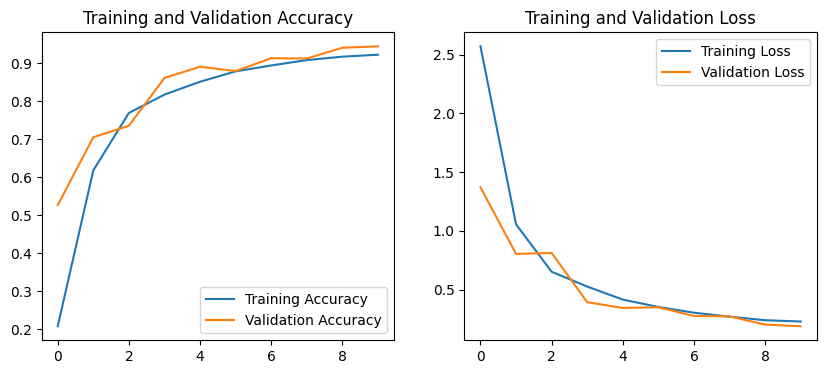

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# This code is used to plot the training and validation accuracy
epochs_range = range(len(acc))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:
y_test_decode = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=-1)
cf_matrix = confusion_matrix(y_test_decode, y_pred)
f1 = f1_score(y_test_decode, y_pred, average='macro')
recall = recall_score(y_test_decode, y_pred, average='macro')
precision = precision_score(y_test_decode, y_pred, average='macro')
f1, recall, precision

101/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1713784699.178374     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


W0000 00:00:1713784699.990495     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


(0.9191205409348603, 0.9213013416302586, 0.9250389233930228)

<Axes: title={'center': 'Confusion Matrix - American Sign Language (CNN)'}, xlabel='Predicted', ylabel='Actual'>

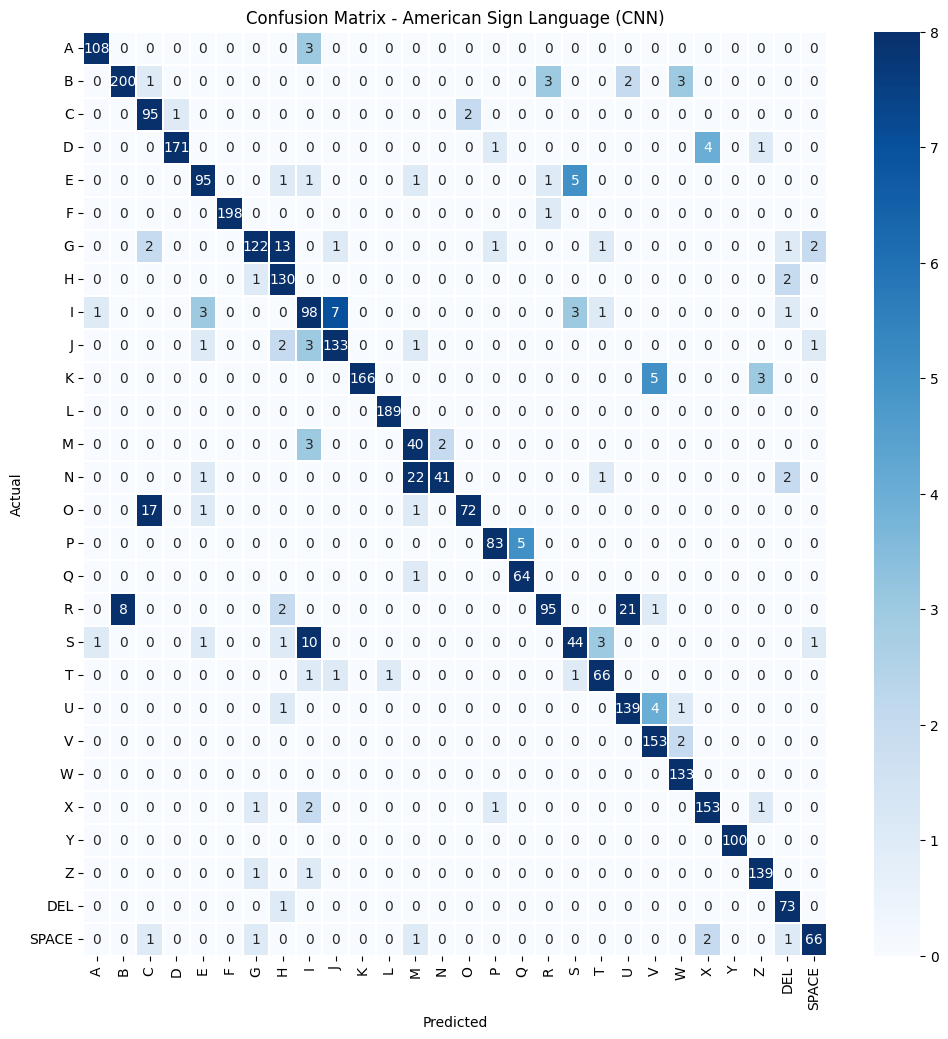

In [49]:
labels = sorted(list(set(df['Output'])))
labels = [x.upper() for x in labels]

fig, ax = plt.subplots(figsize=(12, 12))

ax.set_title("Confusion Matrix - American Sign Language (CNN)")

maping = sns.heatmap(cf_matrix, 
                     annot=True,
                     cmap = plt.cm.Blues, 
                     linewidths=.2,
                     xticklabels=labels,
                     yticklabels=labels, vmax=8,
                     fmt='g',
                     ax=ax
                    )
plt.ylabel('Actual')
plt.xlabel('Predicted')
maping

In [50]:
maping.figure.savefig("output_cnn.png")

In [51]:
#Saving the model into H5 system file
save_model = "/kaggle/working/model_cnn.h5"
model.save(save_model)
print("Model Saved into", save_model)

Model Saved into /kaggle/working/model_cnn.h5


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


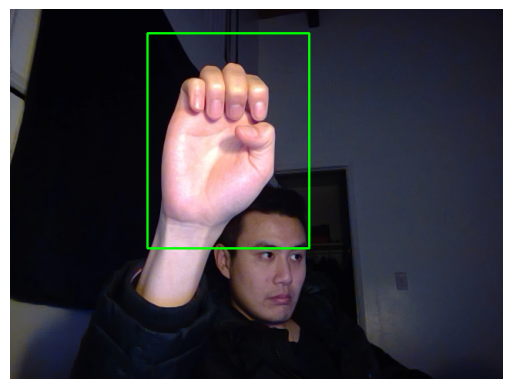

In [4]:
# Đường dẫn đến tấm ảnh
image_path = '/kaggle/input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset/asl_alphabet_train/E/10.jpg'

# Đọc ảnh
image = cv2.imread(image_path)

# Khởi tạo mô-đun Mediapipe Hands
mp_hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=1)

# Chuyển đổi màu sắc từ BGR sang RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Phát hiện tay trong ảnh
results = mp_hands.process(image_rgb)

# Kiểm tra xem có tay được phát hiện hay không
if results.multi_hand_landmarks:
    # Lấy tọa độ các điểm đặc trưng của tay
    hand_landmarks = results.multi_hand_landmarks[0]

    # Tính toán tọa độ của hình chữ nhật bao quanh tay
    x_min = min(int(lm.x * image.shape[1]) for lm in hand_landmarks.landmark) - 50
    x_max = max(int(lm.x * image.shape[1]) for lm in hand_landmarks.landmark) + 50
    y_min = min(int(lm.y * image.shape[0]) for lm in hand_landmarks.landmark) - 50
    y_max = max(int(lm.y * image.shape[0]) for lm in hand_landmarks.landmark) + 50

    # Vẽ hình chữ nhật lên ảnh
    cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
plt.imshow(image_rgb)
plt.axis('off')  # Tắt trục tọa độ
plt.show()